## First Algorithm

In this algo we will 

- Download Google' stock price.
- Calculate the daily price difference (from the previous trading day)
- If the price difference is positive then, invest all the capital (100%) in Google
- If the difference is negative then we sell the stock and convert 100% capital into cash


First import our packages

In [8]:
import pandas as pd
import numpy as np

from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.filters import Q500US, StaticAssets, StaticSids
from quantopian.pipeline.factors import CustomFactor

In [9]:
start_date = '2004-1-1'
end_date = '2020-1-30'

We will build a custom factor to calculate the difference between the daily price data.

In [10]:
class diff_2day(CustomFactor):
    
    def compute(self, today, assets, out, values):
        
        out[:] = np.diff(values, axis = 0)

In [11]:
def make_pipeline():
    
    universe = StaticSids([26578])
    
    close = USEquityPricing.close.latest
    
    diff = diff_2day(
        inputs = [USEquityPricing.close], 
                     window_length = 2,
        mask = universe
    )
    
    return Pipeline(
    
        columns = {
            
            'close':close,
            'diff':diff
        },screen = universe
    )

In [12]:
output = run_pipeline(make_pipeline(),
                     start_date,
                     end_date)

output.head()

,,close,diff
2004-08-20 00:00:00+00:00,Equity(26578 [GOOG_L]),100.37,NaN
2004-08-23 00:00:00+00:00,Equity(26578 [GOOG_L]),108.32,7.95
2004-08-24 00:00:00+00:00,Equity(26578 [GOOG_L]),109.49,1.17
2004-08-25 00:00:00+00:00,Equity(26578 [GOOG_L]),104.96,-4.53
2004-08-26 00:00:00+00:00,Equity(26578 [GOOG_L]),105.83,0.87


#### Our Algo to be run in Quantopian's Algorithm

"""
This is a template for our algorithm Buying GOOGLE stock based on the signal.
"""
import quantopian.algorithm as algo
import pandas as pd
import numpy as np

from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.filters import Q500US, StaticAssets, StaticSids
from quantopian.pipeline.factors import CustomFactor

set_slippage(slippage.FixedSlippage(spread = 0))

def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    # Rebalance every day, 1 hour after market open.
    
    context.goog = sid(26578)
    
    algo.schedule_function(
        rebalance,
        algo.date_rules.every_day(),
        algo.time_rules.market_open(hours=1),
    )

    # Record tracking variables at the end of each day.
    algo.schedule_function(
        record_vars,
        algo.date_rules.every_day(),
        algo.time_rules.market_close(),
    )

    # Create our dynamic stock selector.
    algo.attach_pipeline(make_pipeline(), 'pipeline')
    


class diff_2day(CustomFactor):
    
    def compute(self, today, assets, out, values):
        
        out[:] = np.diff(values, axis = 0)
        
def make_pipeline():
    
    universe = StaticSids([26578])
    
    close = USEquityPricing.close.latest
    
    diff = diff_2day(
        inputs = [USEquityPricing.close], 
                     window_length = 2,
        mask = universe
    )
    
    return Pipeline(
    
        columns = {
            
            'close':close,
            'diff':diff
        },screen = universe
    )


def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    context.output = algo.pipeline_output('pipeline')

    # These are the securities that we are interested in trading each day.
    context.diff = context.output['diff'].values
    context.stocks = context.output.index.tolist()
 
def rebalance(context, data):
    """
    Execute orders according to our schedule_function() timing.
    """
    
    if context.diff > 0.0:
        stock_weight = 1.0
    else:
        stock_weight = 0
        
    order_target_percent(context.goog,stock_weight)        


def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    #value = context.portfolio.positions_value
    m = len(context.stocks)
    record(n_stocks = m)
    
    

### Getting our Backtest Result

In [1]:
bt = get_backtest('5e44732efcaa62484f70a6fc')

100% Time:  0:00:01|##########################################################|


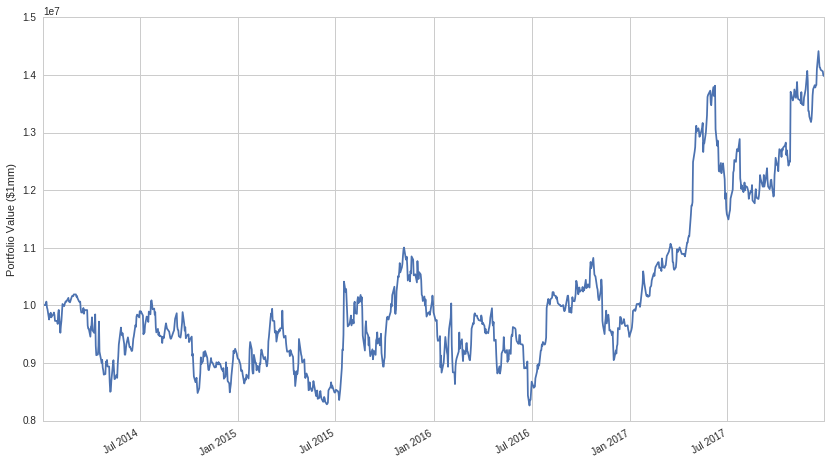

In [7]:
import matplotlib.pyplot as plt
bt.cumulative_performance['ending_portfolio_value'].plot()
plt.ylabel('Portfolio Value ($1mm)')